In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torchvision
import torchvision.transforms as transforms

/home/aban/somu/deep3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
from torch.utils.data import random_split
torch.manual_seed(43)
val_size = 5000
train_size = len(train_set) - val_size
train_set, val_set = random_split(train_set, [train_size, val_size])
len(train_set), len(val_set)

(45000, 5000)

In [6]:
# Create data loaders for batch processing
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64,shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=len(val_set),shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64,shuffle=False, num_workers=2)

In [9]:
class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True

# PamdaNet3 with tanh and  Adam optimizer

In [11]:
import torch.nn as nn
from torchsummary import summary
import torch.nn.functional as F

# Define the CNN architecture
class PandaNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1) #(depth of each conv2d,noof conv2d)
        self.conv2 = nn.Conv2d(32,64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(128,256, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.batch_norm1 = nn.BatchNorm2d(num_features=64)
        self.batch_norm2 = nn.BatchNorm2d(num_features=128)
        self.batch_norm3 = nn.BatchNorm2d(num_features=256)
        
        self.fc1 = nn.Linear(256 * 4 * 4,1024)
        self.fc2 = nn.Linear(1024,512)
        self.fc3 = nn.Linear(512, 10)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.tanh(self.conv1(x)) 
        x = self.pool(self.tanh(self.conv2(x)))
        x = self.batch_norm1(x)
        x = self.tanh(self.conv3(x))
        x = self.pool(self.tanh(self.conv4(x)))
        x = self.batch_norm2(x)
        x = self.tanh(self.conv5(x))
        x = self.pool(self.tanh(self.conv6(x)))
        x = self.batch_norm3(x)
        
        x = x.view(-1, 256 * 4 * 4)
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x,dim=1)

# Create an instance of the CNN
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
PandaNet = PandaNet().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(PandaNet.parameters(), lr=0.001)
print(device)
print(PandaNet)

cuda:1
PandaNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): L

In [12]:
from tqdm import tqdm
import time

start_time = time.time()

train_loss = []
train_accuracy = []
validation_loss = []
validation_accuracy = []

early_stopping = EarlyStopping(tolerance=5, min_delta=10)

for epoch in tqdm(range(50),desc="Loading..."):
    correct = 0
    total = 0
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = PandaNet(images)
        loss = criterion(outputs, labels)
        
        #checking Training Accuracy
        with torch.no_grad():
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    #testing val_acuuracy after each epoch
    total_val = 0
    correct_val = 0
    with torch.no_grad():
        for im_val,label_val in val_loader:
            im_val, label_val = im_val.to(device), label_val.to(device)
            output_val = PandaNet(im_val)
            val_loss = criterion(output_val, label_val)
            _, predicted_val = torch.max(output_val.data, 1)
            total_val += label_val.size(0)
            correct_val += (predicted_val == label_val).sum().item()

            
    print ('Epoch {} | Training Loss {:.2f} | Training Accuracy {:.2f}% | Validation Loss  {:.2f}| Validation Accuracy {}%'.format(epoch+1,running_loss/782,(100 * correct / total),(val_loss.item()),(100*correct_val/total_val)))
        
    train_loss.append(running_loss/782)
    train_accuracy.append(100 * correct / total)
    validation_loss.append(val_loss.item())
    validation_accuracy.append(100*correct_val/total_val)
    
    # early stopping
    early_stopping(running_loss/782, val_loss.item())
    if early_stopping.early_stop:
      print('early stop')
      break
        
torch.save(PandaNet.state_dict(), 'PandaNet3.pth')
    
end_time = time.time()
# Calculate the execution time
execution_time = end_time - start_time
# Print the execution time in seconds
print("Training time:", execution_time, "seconds")

Loading...:   2%|▏         | 1/50 [00:08<07:13,  8.84s/it]

Epoch 1 | Training Loss 1.42 | Training Accuracy 42.92% | Validation Loss  1.33| Validation Accuracy 51.1%


Loading...:   4%|▍         | 2/50 [00:17<06:52,  8.59s/it]

Epoch 2 | Training Loss 1.06 | Training Accuracy 57.81% | Validation Loss  1.10| Validation Accuracy 61.36%


Loading...:   6%|▌         | 3/50 [00:25<06:40,  8.52s/it]

Epoch 3 | Training Loss 0.94 | Training Accuracy 62.82% | Validation Loss  1.02| Validation Accuracy 64.22%


Loading...:   8%|▊         | 4/50 [00:34<06:31,  8.51s/it]

Epoch 4 | Training Loss 0.88 | Training Accuracy 65.16% | Validation Loss  0.99| Validation Accuracy 64.2%


Loading...:  10%|█         | 5/50 [00:42<06:23,  8.51s/it]

Epoch 5 | Training Loss 0.84 | Training Accuracy 66.92% | Validation Loss  0.90| Validation Accuracy 68.72%


Loading...:  12%|█▏        | 6/50 [00:51<06:15,  8.53s/it]

Epoch 6 | Training Loss 0.80 | Training Accuracy 68.37% | Validation Loss  0.91| Validation Accuracy 67.76%


Loading...:  14%|█▍        | 7/50 [00:59<06:06,  8.52s/it]

Epoch 7 | Training Loss 0.77 | Training Accuracy 69.33% | Validation Loss  0.89| Validation Accuracy 67.94%


Loading...:  16%|█▌        | 8/50 [01:08<05:56,  8.50s/it]

Epoch 8 | Training Loss 0.77 | Training Accuracy 69.71% | Validation Loss  0.87| Validation Accuracy 69.94%


Loading...:  18%|█▊        | 9/50 [01:16<05:48,  8.50s/it]

Epoch 9 | Training Loss 0.75 | Training Accuracy 70.59% | Validation Loss  0.89| Validation Accuracy 69.28%


Loading...:  20%|██        | 10/50 [01:25<05:38,  8.46s/it]

Epoch 10 | Training Loss 0.74 | Training Accuracy 70.90% | Validation Loss  0.85| Validation Accuracy 69.98%


Loading...:  22%|██▏       | 11/50 [01:33<05:29,  8.46s/it]

Epoch 11 | Training Loss 0.72 | Training Accuracy 71.96% | Validation Loss  0.87| Validation Accuracy 70.06%


Loading...:  24%|██▍       | 12/50 [01:41<05:20,  8.45s/it]

Epoch 12 | Training Loss 0.72 | Training Accuracy 71.72% | Validation Loss  0.86| Validation Accuracy 68.9%


Loading...:  26%|██▌       | 13/50 [01:50<05:12,  8.46s/it]

Epoch 13 | Training Loss 0.72 | Training Accuracy 71.91% | Validation Loss  0.85| Validation Accuracy 70.48%


Loading...:  28%|██▊       | 14/50 [01:58<05:04,  8.46s/it]

Epoch 14 | Training Loss 0.71 | Training Accuracy 72.05% | Validation Loss  0.86| Validation Accuracy 69.66%


Loading...:  30%|███       | 15/50 [02:07<04:56,  8.46s/it]

Epoch 15 | Training Loss 0.72 | Training Accuracy 71.82% | Validation Loss  0.83| Validation Accuracy 70.98%


Loading...:  32%|███▏      | 16/50 [02:15<04:46,  8.43s/it]

Epoch 16 | Training Loss 0.71 | Training Accuracy 72.03% | Validation Loss  0.83| Validation Accuracy 71.28%


Loading...:  34%|███▍      | 17/50 [02:24<04:39,  8.47s/it]

Epoch 17 | Training Loss 0.70 | Training Accuracy 72.40% | Validation Loss  0.81| Validation Accuracy 71.42%


Loading...:  36%|███▌      | 18/50 [02:32<04:30,  8.45s/it]

Epoch 18 | Training Loss 0.71 | Training Accuracy 72.06% | Validation Loss  0.88| Validation Accuracy 69.34%


Loading...:  38%|███▊      | 19/50 [02:41<04:21,  8.45s/it]

Epoch 19 | Training Loss 0.71 | Training Accuracy 72.00% | Validation Loss  0.83| Validation Accuracy 71.06%


Loading...:  40%|████      | 20/50 [02:49<04:13,  8.46s/it]

Epoch 20 | Training Loss 0.70 | Training Accuracy 72.39% | Validation Loss  0.80| Validation Accuracy 72.32%


Loading...:  42%|████▏     | 21/50 [02:58<04:05,  8.46s/it]

Epoch 21 | Training Loss 0.70 | Training Accuracy 72.73% | Validation Loss  0.83| Validation Accuracy 70.1%


Loading...:  44%|████▍     | 22/50 [03:06<03:57,  8.47s/it]

Epoch 22 | Training Loss 0.70 | Training Accuracy 72.62% | Validation Loss  0.82| Validation Accuracy 71.5%


Loading...:  46%|████▌     | 23/50 [03:15<03:48,  8.48s/it]

Epoch 23 | Training Loss 0.70 | Training Accuracy 72.44% | Validation Loss  0.88| Validation Accuracy 69.62%


Loading...:  48%|████▊     | 24/50 [03:23<03:39,  8.45s/it]

Epoch 24 | Training Loss 0.70 | Training Accuracy 72.65% | Validation Loss  0.86| Validation Accuracy 70.7%


Loading...:  50%|█████     | 25/50 [03:31<03:30,  8.40s/it]

Epoch 25 | Training Loss 0.70 | Training Accuracy 72.51% | Validation Loss  0.84| Validation Accuracy 70.72%


Loading...:  52%|█████▏    | 26/50 [03:40<03:22,  8.44s/it]

Epoch 26 | Training Loss 0.70 | Training Accuracy 72.67% | Validation Loss  0.81| Validation Accuracy 71.4%


Loading...:  54%|█████▍    | 27/50 [03:48<03:14,  8.46s/it]

Epoch 27 | Training Loss 0.71 | Training Accuracy 72.49% | Validation Loss  0.86| Validation Accuracy 70.22%


Loading...:  56%|█████▌    | 28/50 [03:57<03:06,  8.49s/it]

Epoch 28 | Training Loss 0.70 | Training Accuracy 72.83% | Validation Loss  0.81| Validation Accuracy 71.48%


Loading...:  58%|█████▊    | 29/50 [04:05<02:58,  8.49s/it]

Epoch 29 | Training Loss 0.70 | Training Accuracy 72.74% | Validation Loss  0.84| Validation Accuracy 69.88%


Loading...:  60%|██████    | 30/50 [04:14<02:49,  8.48s/it]

Epoch 30 | Training Loss 0.71 | Training Accuracy 72.43% | Validation Loss  0.81| Validation Accuracy 71.44%


Loading...:  62%|██████▏   | 31/50 [04:22<02:41,  8.50s/it]

Epoch 31 | Training Loss 0.70 | Training Accuracy 72.45% | Validation Loss  0.81| Validation Accuracy 71.58%


Loading...:  64%|██████▍   | 32/50 [04:31<02:33,  8.52s/it]

Epoch 32 | Training Loss 0.71 | Training Accuracy 72.39% | Validation Loss  0.82| Validation Accuracy 72.12%


Loading...:  66%|██████▌   | 33/50 [04:39<02:23,  8.46s/it]

Epoch 33 | Training Loss 0.70 | Training Accuracy 72.57% | Validation Loss  0.84| Validation Accuracy 70.54%


Loading...:  68%|██████▊   | 34/50 [04:48<02:15,  8.48s/it]

Epoch 34 | Training Loss 0.71 | Training Accuracy 72.18% | Validation Loss  0.85| Validation Accuracy 70.02%


Loading...:  70%|███████   | 35/50 [04:56<02:07,  8.51s/it]

Epoch 35 | Training Loss 0.71 | Training Accuracy 72.28% | Validation Loss  0.82| Validation Accuracy 71.26%


Loading...:  72%|███████▏  | 36/50 [05:05<01:59,  8.51s/it]

Epoch 36 | Training Loss 0.71 | Training Accuracy 72.27% | Validation Loss  0.81| Validation Accuracy 71.72%


Loading...:  74%|███████▍  | 37/50 [05:13<01:50,  8.53s/it]

Epoch 37 | Training Loss 0.70 | Training Accuracy 72.61% | Validation Loss  0.82| Validation Accuracy 71.56%


Loading...:  76%|███████▌  | 38/50 [05:22<01:42,  8.51s/it]

Epoch 38 | Training Loss 0.71 | Training Accuracy 72.75% | Validation Loss  0.83| Validation Accuracy 71.22%


Loading...:  78%|███████▊  | 39/50 [05:30<01:33,  8.52s/it]

Epoch 39 | Training Loss 0.71 | Training Accuracy 72.26% | Validation Loss  0.85| Validation Accuracy 70.6%


Loading...:  80%|████████  | 40/50 [05:39<01:25,  8.50s/it]

Epoch 40 | Training Loss 0.72 | Training Accuracy 72.09% | Validation Loss  0.87| Validation Accuracy 70.26%


Loading...:  82%|████████▏ | 41/50 [05:47<01:16,  8.46s/it]

Epoch 41 | Training Loss 0.72 | Training Accuracy 71.70% | Validation Loss  0.88| Validation Accuracy 69.54%


Loading...:  84%|████████▍ | 42/50 [05:56<01:07,  8.47s/it]

Epoch 42 | Training Loss 0.73 | Training Accuracy 71.86% | Validation Loss  0.87| Validation Accuracy 69.54%


Loading...:  86%|████████▌ | 43/50 [06:04<00:59,  8.49s/it]

Epoch 43 | Training Loss 0.73 | Training Accuracy 71.38% | Validation Loss  0.86| Validation Accuracy 69.94%


Loading...:  88%|████████▊ | 44/50 [06:13<00:50,  8.49s/it]

Epoch 44 | Training Loss 0.74 | Training Accuracy 71.47% | Validation Loss  0.85| Validation Accuracy 70.12%


Loading...:  90%|█████████ | 45/50 [06:21<00:42,  8.45s/it]

Epoch 45 | Training Loss 0.71 | Training Accuracy 72.14% | Validation Loss  0.86| Validation Accuracy 69.88%


Loading...:  92%|█████████▏| 46/50 [06:30<00:33,  8.47s/it]

Epoch 46 | Training Loss 0.74 | Training Accuracy 71.02% | Validation Loss  0.89| Validation Accuracy 68.48%


Loading...:  94%|█████████▍| 47/50 [06:38<00:25,  8.47s/it]

Epoch 47 | Training Loss 0.74 | Training Accuracy 70.88% | Validation Loss  0.91| Validation Accuracy 68.4%


Loading...:  96%|█████████▌| 48/50 [06:47<00:16,  8.48s/it]

Epoch 48 | Training Loss 0.75 | Training Accuracy 71.06% | Validation Loss  0.86| Validation Accuracy 69.84%


Loading...:  98%|█████████▊| 49/50 [06:55<00:08,  8.45s/it]

Epoch 49 | Training Loss 0.72 | Training Accuracy 72.23% | Validation Loss  0.89| Validation Accuracy 69.14%


Loading...: 100%|██████████| 50/50 [07:03<00:00,  8.48s/it]

Epoch 50 | Training Loss 0.73 | Training Accuracy 71.53% | Validation Loss  0.86| Validation Accuracy 69.94%
Training time: 423.98664808273315 seconds


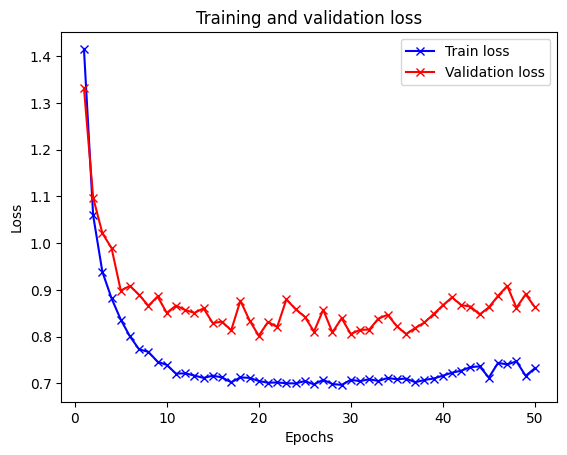

In [13]:
import matplotlib.pyplot as plt

# Define the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the train loss and val loss
plt.plot(epochs, train_loss, '-bx', label='Train loss')
plt.plot(epochs, validation_loss, '-rx', label='Validation loss')


# Set the title and labels for the graph
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Add a legend to the graph
plt.legend()

# Show the graph
plt.show()

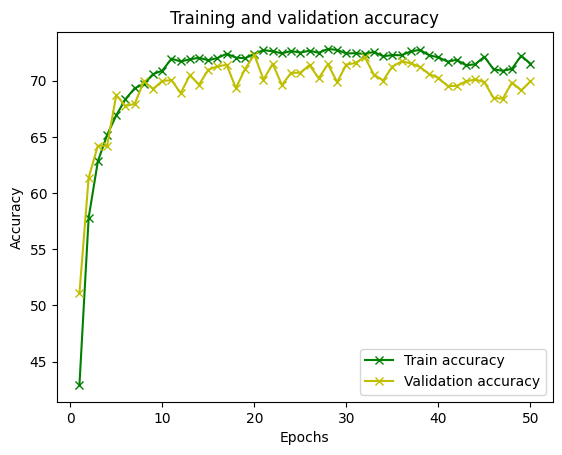

In [14]:
epochs = range(1, len(train_loss) + 1)
# Plot the train accuracy and val accuracy
plt.plot(epochs, train_accuracy, '-gx', label='Train accuracy')
plt.plot(epochs, validation_accuracy, '-yx', label='Validation accuracy')
# Set the title and labels for the graph
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Add a legend to the graph
plt.legend()

# Show the graph
plt.show()

In [15]:
# Evaluate the CNN on the test set
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = PandaNet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Print the accuracy
print('Accuracy of the pre-trained CNN on the 10000 test images: {} %'.format(100 * correct / total))

Accuracy of the pre-trained CNN on the 10000 test images: 69.69 %


# PandaNet3 with Sigmoid and RMSprop

In [17]:
import torch.nn as nn
from torchsummary import summary
import torch.nn.functional as F

# Define the CNN architecture
class PandaNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1) #(depth of each conv2d,noof conv2d)
        self.conv2 = nn.Conv2d(32,64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(128,256, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.batch_norm1 = nn.BatchNorm2d(num_features=64)
        self.batch_norm2 = nn.BatchNorm2d(num_features=128)
        self.batch_norm3 = nn.BatchNorm2d(num_features=256)
        
        self.fc1 = nn.Linear(256 * 4 * 4,1024)
        self.fc2 = nn.Linear(1024,512)
        self.fc3 = nn.Linear(512, 10)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.sigmoid(self.conv1(x)) 
        x = self.pool(self.sigmoid(self.conv2(x)))
        x = self.batch_norm1(x)
        x = self.sigmoid(self.conv3(x))
        x = self.pool(self.sigmoid(self.conv4(x)))
        x = self.batch_norm2(x)
        x = self.sigmoid(self.conv5(x))
        x = self.pool(self.sigmoid(self.conv6(x)))
        x = self.batch_norm3(x)
        
        x = x.view(-1, 256 * 4 * 4)
        x = self.sigmoid(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x,dim=1)

# Create an instance of the CNN
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
PandaNet = PandaNet().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.RMSprop(PandaNet.parameters(), lr=0.001)
print(device)
print(PandaNet)

cuda:1
PandaNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): L

In [18]:
from tqdm import tqdm
import time

start_time = time.time()

train_loss = []
train_accuracy = []
validation_loss = []
validation_accuracy = []

early_stopping = EarlyStopping(tolerance=5, min_delta=10)

for epoch in tqdm(range(50),desc="Loading..."):
    correct = 0
    total = 0
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = PandaNet(images)
        loss = criterion(outputs, labels)
        
        #checking Training Accuracy
        with torch.no_grad():
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    #testing val_acuuracy after each epoch
    total_val = 0
    correct_val = 0
    with torch.no_grad():
        for im_val,label_val in val_loader:
            im_val, label_val = im_val.to(device), label_val.to(device)
            output_val = PandaNet(im_val)
            val_loss = criterion(output_val, label_val)
            _, predicted_val = torch.max(output_val.data, 1)
            total_val += label_val.size(0)
            correct_val += (predicted_val == label_val).sum().item()

            
    print ('Epoch {} | Training Loss {:.2f} | Training Accuracy {:.2f}% | Validation Loss  {:.2f}| Validation Accuracy {}%'.format(epoch+1,running_loss/782,(100 * correct / total),(val_loss.item()),(100*correct_val/total_val)))
        
    train_loss.append(running_loss/782)
    train_accuracy.append(100 * correct / total)
    validation_loss.append(val_loss.item())
    validation_accuracy.append(100*correct_val/total_val)
    
    # early stopping
    early_stopping(running_loss/782, val_loss.item())
    if early_stopping.early_stop:
      print('early stop')
      break
        
torch.save(PandaNet.state_dict(), 'PandaNet3.pth')
    
end_time = time.time()
# Calculate the execution time
execution_time = end_time - start_time
# Print the execution time in seconds
print("Training time:", execution_time, "seconds")

Loading...:   2%|▏         | 1/50 [00:08<06:39,  8.16s/it]

Epoch 1 | Training Loss 1.57 | Training Accuracy 35.43% | Validation Loss  1.57| Validation Accuracy 41.24%


Loading...:   4%|▍         | 2/50 [00:16<06:32,  8.18s/it]

Epoch 2 | Training Loss 1.18 | Training Accuracy 52.60% | Validation Loss  1.30| Validation Accuracy 52.66%


Loading...:   6%|▌         | 3/50 [00:24<06:23,  8.15s/it]

Epoch 3 | Training Loss 0.97 | Training Accuracy 61.67% | Validation Loss  1.23| Validation Accuracy 56.68%


Loading...:   8%|▊         | 4/50 [00:32<06:14,  8.15s/it]

Epoch 4 | Training Loss 0.83 | Training Accuracy 67.36% | Validation Loss  1.09| Validation Accuracy 64.12%


Loading...:  10%|█         | 5/50 [00:40<06:06,  8.14s/it]

Epoch 5 | Training Loss 0.73 | Training Accuracy 71.26% | Validation Loss  0.89| Validation Accuracy 68.9%


Loading...:  12%|█▏        | 6/50 [00:48<05:58,  8.15s/it]

Epoch 6 | Training Loss 0.66 | Training Accuracy 74.43% | Validation Loss  1.06| Validation Accuracy 65.44%


Loading...:  14%|█▍        | 7/50 [00:57<05:50,  8.16s/it]

Epoch 7 | Training Loss 0.61 | Training Accuracy 76.44% | Validation Loss  0.73| Validation Accuracy 75.5%


Loading...:  16%|█▌        | 8/50 [01:05<05:42,  8.16s/it]

Epoch 8 | Training Loss 0.56 | Training Accuracy 78.28% | Validation Loss  0.72| Validation Accuracy 74.58%


Loading...:  18%|█▊        | 9/50 [01:13<05:35,  8.17s/it]

Epoch 9 | Training Loss 0.52 | Training Accuracy 80.01% | Validation Loss  0.63| Validation Accuracy 78.86%


Loading...:  20%|██        | 10/50 [01:21<05:26,  8.16s/it]

Epoch 10 | Training Loss 0.49 | Training Accuracy 81.09% | Validation Loss  0.66| Validation Accuracy 76.56%


Loading...:  22%|██▏       | 11/50 [01:29<05:18,  8.16s/it]

Epoch 11 | Training Loss 0.46 | Training Accuracy 82.11% | Validation Loss  0.60| Validation Accuracy 79.7%


Loading...:  24%|██▍       | 12/50 [01:37<05:10,  8.16s/it]

Epoch 12 | Training Loss 0.44 | Training Accuracy 83.06% | Validation Loss  0.65| Validation Accuracy 78.86%


Loading...:  26%|██▌       | 13/50 [01:46<05:01,  8.16s/it]

Epoch 13 | Training Loss 0.41 | Training Accuracy 83.98% | Validation Loss  0.54| Validation Accuracy 81.22%


Loading...:  28%|██▊       | 14/50 [01:54<04:53,  8.15s/it]

Epoch 14 | Training Loss 0.40 | Training Accuracy 84.59% | Validation Loss  0.70| Validation Accuracy 77.3%


Loading...:  30%|███       | 15/50 [02:02<04:44,  8.14s/it]

Epoch 15 | Training Loss 0.38 | Training Accuracy 85.17% | Validation Loss  0.57| Validation Accuracy 80.4%


Loading...:  32%|███▏      | 16/50 [02:10<04:38,  8.20s/it]

Epoch 16 | Training Loss 0.36 | Training Accuracy 85.87% | Validation Loss  0.53| Validation Accuracy 82.4%


Loading...:  34%|███▍      | 17/50 [02:18<04:30,  8.19s/it]

Epoch 17 | Training Loss 0.35 | Training Accuracy 86.38% | Validation Loss  0.53| Validation Accuracy 82.02%


Loading...:  36%|███▌      | 18/50 [02:27<04:22,  8.19s/it]

Epoch 18 | Training Loss 0.34 | Training Accuracy 86.68% | Validation Loss  0.57| Validation Accuracy 81.44%


Loading...:  38%|███▊      | 19/50 [02:35<04:13,  8.19s/it]

Epoch 19 | Training Loss 0.33 | Training Accuracy 87.23% | Validation Loss  0.56| Validation Accuracy 81.78%


Loading...:  40%|████      | 20/50 [02:43<04:05,  8.20s/it]

Epoch 20 | Training Loss 0.31 | Training Accuracy 87.89% | Validation Loss  0.52| Validation Accuracy 82.7%


Loading...:  42%|████▏     | 21/50 [02:51<03:57,  8.19s/it]

Epoch 21 | Training Loss 0.31 | Training Accuracy 88.07% | Validation Loss  0.52| Validation Accuracy 82.92%


Loading...:  44%|████▍     | 22/50 [02:59<03:49,  8.19s/it]

Epoch 22 | Training Loss 0.30 | Training Accuracy 88.59% | Validation Loss  0.51| Validation Accuracy 82.64%


Loading...:  46%|████▌     | 23/50 [03:07<03:40,  8.18s/it]

Epoch 23 | Training Loss 0.29 | Training Accuracy 88.71% | Validation Loss  0.54| Validation Accuracy 82.66%


Loading...:  48%|████▊     | 24/50 [03:16<03:33,  8.19s/it]

Epoch 24 | Training Loss 0.28 | Training Accuracy 89.00% | Validation Loss  0.54| Validation Accuracy 82.4%


Loading...:  50%|█████     | 25/50 [03:24<03:24,  8.20s/it]

Epoch 25 | Training Loss 0.28 | Training Accuracy 89.09% | Validation Loss  0.57| Validation Accuracy 81.88%


Loading...:  52%|█████▏    | 26/50 [03:32<03:17,  8.22s/it]

Epoch 26 | Training Loss 0.27 | Training Accuracy 89.60% | Validation Loss  0.48| Validation Accuracy 84.38%


Loading...:  54%|█████▍    | 27/50 [03:40<03:08,  8.21s/it]

Epoch 27 | Training Loss 0.27 | Training Accuracy 89.68% | Validation Loss  0.49| Validation Accuracy 84.1%


Loading...:  56%|█████▌    | 28/50 [03:49<03:01,  8.25s/it]

Epoch 28 | Training Loss 0.26 | Training Accuracy 89.97% | Validation Loss  0.46| Validation Accuracy 85.22%


Loading...:  58%|█████▊    | 29/50 [03:57<02:52,  8.23s/it]

Epoch 29 | Training Loss 0.26 | Training Accuracy 90.01% | Validation Loss  0.54| Validation Accuracy 82.98%


Loading...:  60%|██████    | 30/50 [04:05<02:44,  8.25s/it]

Epoch 30 | Training Loss 0.25 | Training Accuracy 90.24% | Validation Loss  0.53| Validation Accuracy 83.7%


Loading...:  62%|██████▏   | 31/50 [04:13<02:36,  8.24s/it]

Epoch 31 | Training Loss 0.24 | Training Accuracy 90.54% | Validation Loss  0.49| Validation Accuracy 84.08%


Loading...:  64%|██████▍   | 32/50 [04:22<02:28,  8.23s/it]

Epoch 32 | Training Loss 0.24 | Training Accuracy 90.61% | Validation Loss  0.58| Validation Accuracy 81.98%


Loading...:  66%|██████▌   | 33/50 [04:30<02:19,  8.21s/it]

Epoch 33 | Training Loss 0.24 | Training Accuracy 90.70% | Validation Loss  0.49| Validation Accuracy 84.9%


Loading...:  68%|██████▊   | 34/50 [04:38<02:11,  8.20s/it]

Epoch 34 | Training Loss 0.23 | Training Accuracy 91.02% | Validation Loss  0.53| Validation Accuracy 83.16%


Loading...:  70%|███████   | 35/50 [04:46<02:03,  8.21s/it]

Epoch 35 | Training Loss 0.23 | Training Accuracy 91.05% | Validation Loss  0.65| Validation Accuracy 81.1%


Loading...:  72%|███████▏  | 36/50 [04:54<01:54,  8.20s/it]

Epoch 36 | Training Loss 0.23 | Training Accuracy 91.02% | Validation Loss  0.48| Validation Accuracy 84.56%


Loading...:  74%|███████▍  | 37/50 [05:03<01:46,  8.21s/it]

Epoch 37 | Training Loss 0.22 | Training Accuracy 91.19% | Validation Loss  0.51| Validation Accuracy 84.18%


Loading...:  76%|███████▌  | 38/50 [05:11<01:38,  8.19s/it]

Epoch 38 | Training Loss 0.22 | Training Accuracy 91.44% | Validation Loss  0.49| Validation Accuracy 85.0%


Loading...:  78%|███████▊  | 39/50 [05:19<01:29,  8.16s/it]

Epoch 39 | Training Loss 0.22 | Training Accuracy 91.56% | Validation Loss  0.53| Validation Accuracy 83.72%


Loading...:  80%|████████  | 40/50 [05:27<01:21,  8.20s/it]

Epoch 40 | Training Loss 0.22 | Training Accuracy 91.39% | Validation Loss  0.50| Validation Accuracy 84.58%


Loading...:  82%|████████▏ | 41/50 [05:35<01:13,  8.18s/it]

Epoch 41 | Training Loss 0.21 | Training Accuracy 91.62% | Validation Loss  0.63| Validation Accuracy 81.42%


Loading...:  84%|████████▍ | 42/50 [05:43<01:05,  8.19s/it]

Epoch 42 | Training Loss 0.21 | Training Accuracy 92.03% | Validation Loss  0.52| Validation Accuracy 84.72%


Loading...:  86%|████████▌ | 43/50 [05:51<00:57,  8.16s/it]

Epoch 43 | Training Loss 0.21 | Training Accuracy 91.86% | Validation Loss  0.58| Validation Accuracy 83.64%


Loading...:  88%|████████▊ | 44/50 [06:00<00:49,  8.18s/it]

Epoch 44 | Training Loss 0.21 | Training Accuracy 91.85% | Validation Loss  0.55| Validation Accuracy 83.68%


Loading...:  90%|█████████ | 45/50 [06:08<00:40,  8.18s/it]

Epoch 45 | Training Loss 0.20 | Training Accuracy 92.11% | Validation Loss  0.52| Validation Accuracy 84.32%


Loading...:  92%|█████████▏| 46/50 [06:16<00:32,  8.19s/it]

Epoch 46 | Training Loss 0.20 | Training Accuracy 92.16% | Validation Loss  0.50| Validation Accuracy 85.12%


Loading...:  94%|█████████▍| 47/50 [06:24<00:24,  8.18s/it]

Epoch 47 | Training Loss 0.20 | Training Accuracy 92.33% | Validation Loss  0.51| Validation Accuracy 84.92%


Loading...:  96%|█████████▌| 48/50 [06:32<00:16,  8.18s/it]

Epoch 48 | Training Loss 0.20 | Training Accuracy 92.24% | Validation Loss  0.47| Validation Accuracy 85.22%


Loading...:  98%|█████████▊| 49/50 [06:41<00:08,  8.19s/it]

Epoch 49 | Training Loss 0.19 | Training Accuracy 92.53% | Validation Loss  0.50| Validation Accuracy 85.52%


Loading...: 100%|██████████| 50/50 [06:49<00:00,  8.19s/it]

Epoch 50 | Training Loss 0.19 | Training Accuracy 92.30% | Validation Loss  0.50| Validation Accuracy 85.02%
Training time: 409.4027626514435 seconds


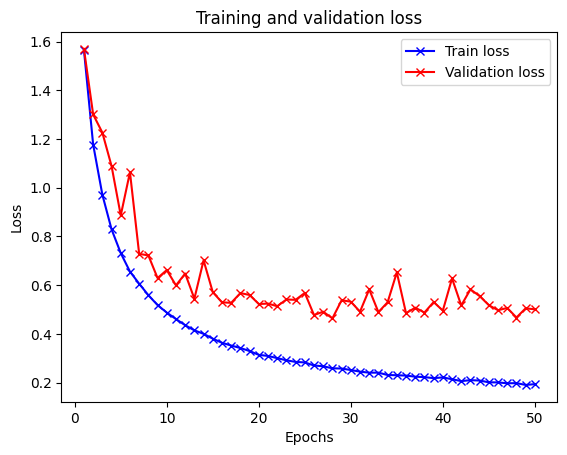

In [19]:
import matplotlib.pyplot as plt

# Define the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the train loss and val loss
plt.plot(epochs, train_loss, '-bx', label='Train loss')
plt.plot(epochs, validation_loss, '-rx', label='Validation loss')


# Set the title and labels for the graph
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Add a legend to the graph
plt.legend()

# Show the graph
plt.show()

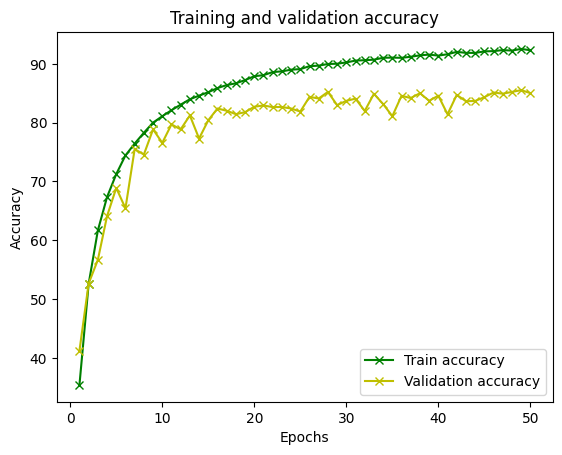

In [20]:
epochs = range(1, len(train_loss) + 1)
# Plot the train accuracy and val accuracy
plt.plot(epochs, train_accuracy, '-gx', label='Train accuracy')
plt.plot(epochs, validation_accuracy, '-yx', label='Validation accuracy')
# Set the title and labels for the graph
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Add a legend to the graph
plt.legend()

# Show the graph
plt.show()

In [21]:
# Evaluate the CNN on the test set
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = PandaNet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Print the accuracy
print('Accuracy of the pre-trained CNN on the 10000 test images: {} %'.format(100 * correct / total))

Accuracy of the pre-trained CNN on the 10000 test images: 84.96 %
